## Imports

In [26]:
# Usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import pickle

In [2]:
pred_df = pd.read_csv('../data/october_tweets.csv')

In [3]:
pred_df.head()

,text,time
0,b'RT @CBSLA: #LIVE: New flames flare-up near M...,2019-10-28 19:01:05
1,b'RT @PauleyP: Los Angeles is ON FIRE AND BURN...,2019-10-28 19:01:05
2,"b'RT @skbaer: @mgafni Last week, PG&amp;E repo...",2019-10-28 19:01:05
3,b'RT @LAist: When driving to safety during a w...,2019-10-28 19:01:04
4,b'It smells like so much smoke here in LA \xf0...,2019-10-28 19:01:02


## Generate predictions

In [4]:
model = pickle.load(open('../code/model.p', 'rb'))

In [5]:
pred_df['predictions'] = model.predict(pred_df['text'])
pred_df.head()

/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['angele', 'angeles', 'center', 'gettyfire', 'los', 'maria'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,text,time,predictions
0,b'RT @CBSLA: #LIVE: New flames flare-up near M...,2019-10-28 19:01:05,1
1,b'RT @PauleyP: Los Angeles is ON FIRE AND BURN...,2019-10-28 19:01:05,1
2,"b'RT @skbaer: @mgafni Last week, PG&amp;E repo...",2019-10-28 19:01:05,1
3,b'RT @LAist: When driving to safety during a w...,2019-10-28 19:01:04,1
4,b'It smells like so much smoke here in LA \xf0...,2019-10-28 19:01:02,0


## Time Series

### Predicted Data set

In [6]:
pred_df['time'] = pd.to_datetime(pred_df['time'])

In [7]:
pred_df.set_index('time', inplace = True)
pred_df.sort_index(inplace = True)
pred_df.head()

,text,predictions
time,,
2019-10-19 17:02:28,b'this last episode of Fire Force... daaaamn',0
2019-10-19 17:18:58,b'RT @sweetmak: Prayers going out there to all...,0
2019-10-19 17:26:59,"b""Don't be depressed about the #ClimateCrisis\...",0
2019-10-19 17:28:01,b'Corporations sell games and stories about ho...,0
2019-10-19 17:37:13,"b""@AlleyCa09646129 @PalmerReport @CherKalleck ...",0


In [8]:
text_df = pred_df[['text']].resample('H').count()

In [9]:
rel_df = pred_df[['predictions']].resample('H').sum()

In [10]:
final_df = pd.concat([text_df, rel_df], axis=1)
final_df.head()

,text,predictions
time,,
2019-10-19 17:00:00,10,1
2019-10-19 18:00:00,17,3
2019-10-19 19:00:00,10,1
2019-10-19 20:00:00,8,3
2019-10-19 21:00:00,15,0


In [11]:
final_df.columns = ['total_tweets', 'relevant_tweets']

In [12]:
final_df.head()

,total_tweets,relevant_tweets
time,,
2019-10-19 17:00:00,10,1
2019-10-19 18:00:00,17,3
2019-10-19 19:00:00,10,1
2019-10-19 20:00:00,8,3
2019-10-19 21:00:00,15,0


In [13]:
final_df.rolling(2).mean()

,total_tweets,relevant_tweets
time,,
2019-10-19 17:00:00,NaN,NaN
2019-10-19 18:00:00,13.5,2.0
2019-10-19 19:00:00,13.5,2.0
2019-10-19 20:00:00,9.0,2.0
2019-10-19 21:00:00,11.5,1.5
...,...,...
2019-11-01 18:00:00,159.0,107.0
2019-11-01 19:00:00,152.0,112.0
2019-11-01 20:00:00,153.5,113.5


In [14]:
final_df = pd.concat([
    final_df,
    final_df.rolling(2).mean().rename(columns={'total_tweets': 'tweets_2day_avg',
                                               'relevant_tweets': 'relevant_2day_avg'})
], axis = 1)

In [15]:
final_df['rolling_difference'] = final_df['relevant_tweets'] - final_df['relevant_2day_avg']

In [16]:
final_df.head()

,total_tweets,relevant_tweets,tweets_2day_avg,relevant_2day_avg,rolling_difference
time,,,,,
2019-10-19 17:00:00,10,1,NaN,NaN,NaN
2019-10-19 18:00:00,17,3,13.5,2.0,1.0
2019-10-19 19:00:00,10,1,13.5,2.0,-1.0
2019-10-19 20:00:00,8,3,9.0,2.0,1.0
2019-10-19 21:00:00,15,0,11.5,1.5,-1.5


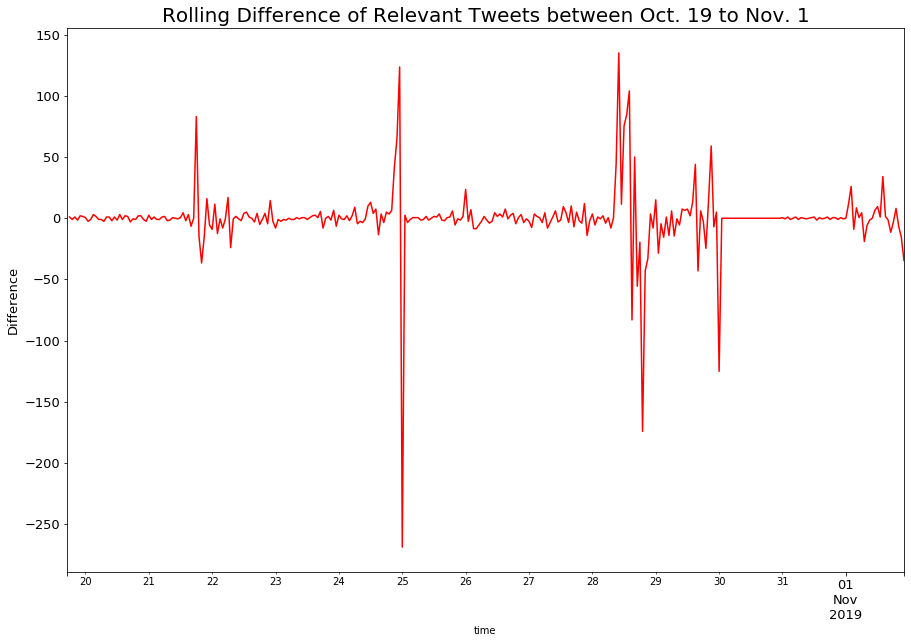

In [78]:
plt.figure(figsize = (15, 10))
plt.title('Rolling Difference of Relevant Tweets between Oct. 19 to Nov. 1', fontsize = 20)
plt.tick_params(labelsize = 13)
plt.ylabel('Difference', fontsize=13)
final_df['rolling_difference'].plot(color = 'r');

In [18]:
final_df['alert_case'] = [1 if item > 43 else 0 for item in final_df['rolling_difference']]

### Alert.ly Data

In [46]:
final_df.sort_index(inplace=True)
alert_class = final_df[['alert_case']]

In [49]:
alert_class.to_csv('../data/alert_classifications.csv')

Data fed to Alert.ly 2.0 to run in the background.